In [1]:
import glob
from timeit import default_timer as timer

import torch
import clip
from PIL import Image

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.special

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
# CONSTANTS
MODEL = "RN50x16"
DATASET = "ISIC_2018"
ADDITIONAL_COMMENTS = "CONCEPT_PROMPTS_8"

In [18]:
# 1. Load Model and Processor
print("[INFO] Loading model...")

if MODEL == "ViT-B-32":
    model, preprocess = clip.load("ViT-B/32", device=device)
elif MODEL == "ViT-B-16":
    model, preprocess = clip.load("ViT-B/16", device=device)
elif MODEL == "RN50":
    model, preprocess = clip.load("RN50", device=device)
elif MODEL == "RN101":
    model, preprocess = clip.load("RN101", device=device)
elif MODEL == "ViT-L-14":
    model, preprocess = clip.load("ViT-L/14", device=device)
elif MODEL == "RN50x16":
    model, preprocess = clip.load("RN50x16", device=device)
elif MODEL == "ViT-B-32-FT":
    model, preprocess = clip.load("ViT-B/32", device=device)
    checkpoint = torch.load("ft_models/model_D7PT.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
elif MODEL == "ViT-B-16-FT":
    model, preprocess = clip.load("ViT-B/16", device=device)
    checkpoint = torch.load("ft_models/model_D7PT_ViT16.pt")
    model.load_state_dict(checkpoint['model_state_dict'])

print("[INFO] Model loaded successfully!")

[INFO] Loading model...
[INFO] Model loaded successfully!


In [19]:
CONCEPT_PROMPTS_8 = {
    "TPN": ["This is dermatoscopy of typical pigment network"],
    "APN": ["This is dermatoscopy of atypical pigment network"],
    "ISTR": ["This is dermatoscopy of irregular streaks"],
    "RSTR": ["This is dermatoscopy of regular streaks"],
    "RDG": ["This is dermatoscopy of regular dots and globules"],
    "IDG": ["This is dermatoscopy of irregular dots and globules"],
    "BWV": ["This is dermatoscopy of blue-whitish veils"],
    "RS": ["This is dermatoscopy of regression structures"]
}

In [20]:
REFERENCE_CONCEPT_PROMPTS = ["This is dermatoscopy"]

In [21]:
# Extract text features for each concept and save it to a numpy array
for disease_label in CONCEPT_PROMPTS_8.keys():
    text = clip.tokenize(CONCEPT_PROMPTS_8[disease_label]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text)
    
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    np.save(f"text_embeddings/concept_8_embeddings_{disease_label}_{MODEL}.npy", text_features.detach().cpu().numpy())
print("[INFO] Completed!")

[INFO] Completed!


In [22]:
from scipy.special import softmax

def get_similarity_score(image_features, text_features):
    similarity = np.dot(image_features, text_features.T)

    return similarity

In [23]:
def calculate_similarity_score(image_features_norm,
                               prompt_target_embedding_norm,
                               prompt_ref_embedding_norm,
                               temp=1,
                               top_k=-1,
                               normalize=True):

    #print(image_features_norm.shape)
    #print(prompt_target_embedding_norm.shape)
    #print(prompt_ref_embedding_norm.shape)

    target_similarity = prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()


    if top_k > 0:
        idx_target = target_similarity.argsort(dim=1, descending=True)
        target_similarity_mean = target_similarity[:,idx_target.squeeze()[:top_k]].mean(dim=1)
        
        ref_similarity_mean = ref_similarity.mean(dim=1)
    else:
        target_similarity_mean = target_similarity.mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    
    if normalize:
        similarity_score = scipy.special.softmax([target_similarity_mean.numpy(), ref_similarity_mean.numpy()], axis=0)[0, :].mean(axis=0)
    else:
        similarity_score = target_similarity_mean.mean(axis=0)

    return similarity_score

In [36]:
# Get image embeddings 
print(f"[INFO] DATASET: {DATASET}")
print(f"[INFO] MODEL: {MODEL}")

img_embeddings = np.load(f"img_embeddings/image_embeddings_{DATASET}_CLIP_{MODEL}_Original.npy", allow_pickle=True).item()
reference_embeddings = torch.from_numpy(np.load(f"concept_embeddings/reference_embeddings_{MODEL}.npy")).unsqueeze(0)
weights_melanoma = np.load("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/PH2Dataset/19-JUL-2023/log_reg_coefs_PH2_8_concepts.npy") # (1, 8)

results = dict()
# Iterate over images and calculate similarity
for im in img_embeddings.keys():
    img_feats = torch.from_numpy(img_embeddings[im]).unsqueeze(0)
    #print(f"IMG shape: {img_feats.shape}")

    similarity_scores = []
    for disease_label in CONCEPT_PROMPTS_8.keys():
        text_feats = torch.from_numpy(np.load(f"text_embeddings/concept_8_embeddings_{disease_label}_{MODEL}.npy")).unsqueeze(0)
        #print(f"TEXT shape: {text_feats.shape}")

        #similarity = get_similarity_score(img_feats, text_feats)
        similarity = calculate_similarity_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats,
                                                prompt_ref_embedding_norm=reference_embeddings,
                                                top_k=-1,
                                                temp=(1/np.exp(4.5944)))

        similarity_scores.append(similarity[0])

    # Calculate prediction given weights of melanoma
    y_pred = np.dot(weights_melanoma, np.array(similarity_scores))
    results[im] = y_pred

[INFO] DATASET: ISIC_2018
[INFO] MODEL: RN50x16


In [37]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc

if DATASET == "PH2":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/PH2Dataset/PH2_dataset.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_test.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "derm7pt":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/Derm7pt/image_classes_derm7pt.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_train_seg.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_validation_seg.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_test_seg.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "ISIC_2018":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/image_classes_ISIC_2018.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/ISIC_2018_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/ISIC_2018_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/ISIC_2018_test.csv")
    test_images = test_images_df["images"].tolist()
    
y_true_val = []
y_pred_probs_val = []
for im in results.keys():

    if str(im) in validation_images:
        if DATASET == "ISIC_2018":
            y_true_val.append(1 if gt.loc[gt['images'] == str(im)]['labels'].tolist()[0] == 3 else 0)
        else:
            y_true_val.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred_probs_val.append(results[im])

fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs_val)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

y_true = []
y_pred = []
y_pred_probs = []
for im in results.keys():
    
    if str(im) in test_images:
        if DATASET == "ISIC_2018":
            y_true.append(1 if gt.loc[gt['images'] == str(im)]['labels'].tolist()[0] == 3 else 0)
        else:
            y_true.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred.append(1 if results[im] > optimal_threshold else 0)
        y_pred_probs.append(results[im])

print(classification_report(y_true=y_true, y_pred=y_pred, target_names=["MEL", "NEV"]))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
print(conf_matrix)

# Calculate AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# BACC
bacc = balanced_accuracy_score(y_true, y_pred)
print(f"BACC: {bacc}")

# Sensitivity
SE = TP / (TP + FN)
print(f"Sensitivity: {SE}")

# Specificity
SP = TN / (TN + FP)
print(f"Specificity: {SP}")

Threshold value is: 1.8989595729385598
              precision    recall  f1-score   support

         MEL       0.92      0.61      0.74      1340
         NEV       0.16      0.56      0.24       171

    accuracy                           0.61      1511
   macro avg       0.54      0.59      0.49      1511
weighted avg       0.83      0.61      0.68      1511

[[824 516]
 [ 76  95]]
AUC: 0.5961682814000174
BACC: 0.585240464344942
Sensitivity: 0.5555555555555556
Specificity: 0.6149253731343284


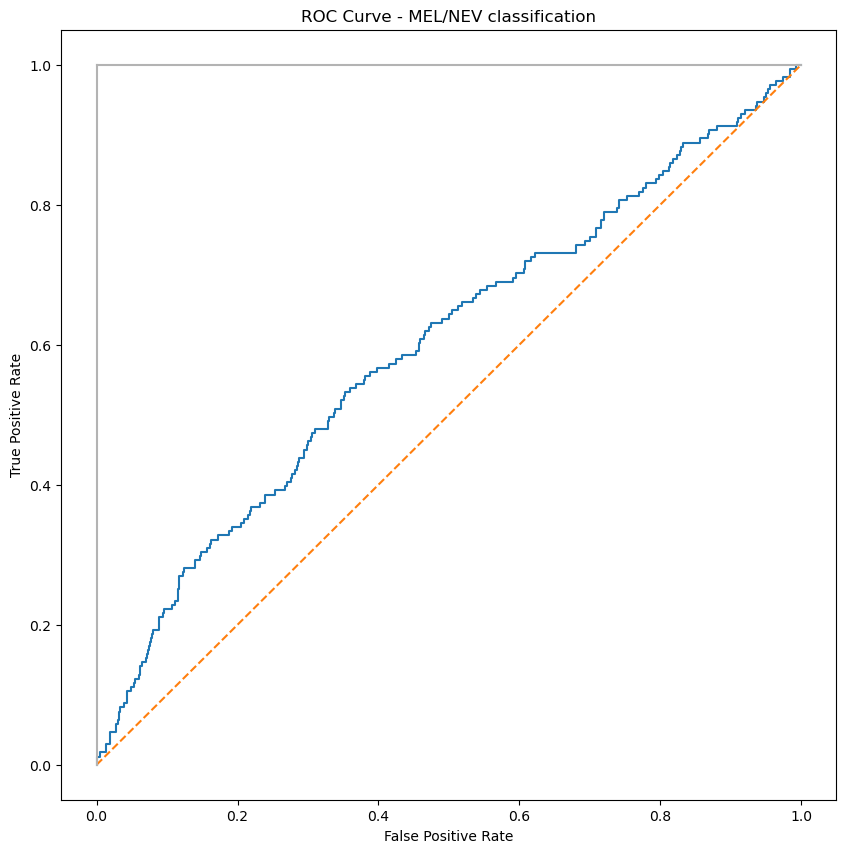

In [38]:
# Plot ROC AUC curve
import matplotlib.pyplot as plt

plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve - MEL/NEV classification')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()